<a href="https://colab.research.google.com/github/bruno-raffa/Quantum-exercises/blob/main/Crop_rotation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop Rotation

This exercise deals with the D-wave example of a "Crop Rotation". Here a problem's description from D-Wave:

*Crop rotation is the agricultural practice of growing a series of different crops in a set of areas, called plots, over time. Crop rotation has benefits that include improved soil structure and reduced dependence on pesticides, herbicides, and fertilizers.* https://github.com/dwave-examples/crop-rotation

The challenge is coped on D-wave using a DQM. In this notebook instead the problem was solved using a CQM. The results obtained with this model show a much *better performance* (in terms of a greater soil utilization), if compared with the DQM used by the authors.

In [ ]:
! pip install dwave-ocean-sdk
! dwave setup

In [2]:
import matplotlib 
import numpy as np
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, Binary, quicksum

from dwave.system import LeapHybridCQMSampler

import urllib.request
from collections import defaultdict

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")

import yaml
import urllib.request
from collections import defaultdict
from matplotlib.colors import hsv_to_rgb
from matplotlib.ticker import MultipleLocator
import random

In [3]:
def read_scenario(filename):
  """Load a problem file.
    Args:
        path (string): Path to input file.
    Returns:
        Tuple of time_units (int), plot_adjacency (dict), and crops (dict).
    """

  try:
    data = list((yaml.safe_load_all(urllib.request.urlopen(filename))))[0]

  except IndexError:
        raise InvalidProblem('empty file')
        
  time_units = data['time_units']
  plot_adjacency = data['plot_adjacency']
  crops = data['crops']

  return time_units, plot_adjacency, crops

In [4]:
def crop_colors(crop_families):
    """Generate colors for crops to be used in visualization of solution.
    All crops should have a unique color and crops in the same family should
    have similar colors.
    Args:
        crop_families (dict):
            Dictionary of crop family names mapped to crops.
    Returns:
        Dictionary of crop names mapped to colors.
    """
    h_scale = 2 / (3 * len(crop_families))
    colors = {}

    for k, crops in enumerate(crop_families.values()):
        h_fam = k / len(crop_families)

        for crop in crops:
            h = h_fam + (random.random() - 0.5) * h_scale
            colors[crop] = (min(1, max(0, h)),
                            0.7 + (random.random() - 0.5) * 0.3,
                            0.7 + (random.random() - 0.5) * 0.3)

    return {crop: hsv_to_rgb(color) for crop, color in colors.items()}

In [5]:
# Set up scenario
filename = 'https://raw.githubusercontent.com/dwave-examples/crop-rotation/main/data/problem1.yaml'
time_units = read_scenario(filename)[0]
plot_adjacency = read_scenario(filename)[1]
crops = read_scenario(filename)[2]

In [6]:
# Reframe the initial data in a more usable way
period_crops = {1 + period: [] for period in range(time_units)}
grow_time = {crop: dict_['grow_time']
                          for crop, dict_ in crops.items()}

crop_families = defaultdict(list)
for crop, dict_ in crops.items():
  for period in range(dict_['planting'][0], dict_['planting'][1] + 1):
      period_crops[period].append(crop)
  crop_families[dict_['family']].append(crop)


_crop_r = []
for crop in crops.keys():
    range_ = range(grow_time[crop])
    _crop_r.extend([(crop, r) for r in range_])

_neighbor_pairs = []
for plot, neighbors in plot_adjacency.items():
    _neighbor_pairs.extend([(plot, v) for v in neighbors])

crop_colors = crop_colors(crop_families)

In [7]:
def build_cqm(time_units=time_units, plot_adjacency=plot_adjacency):

  print("\nBuilding a CQM for {} plots spanning {} months ........".format(str(len(plot_adjacency)), str(time_units)))

  cqm = ConstrainedQuadraticModel()
  objective = - (quicksum(x[k][j][i] * t_i 
                      for i, (crop_, t_i) in enumerate (grow_time.items()) 
                      for j in range(time_units) if crop_ in period_crops[j+1] 
                      for k in range(len(plot_adjacency)) 
    )
  )
    
  cqm.set_objective(objective)

  # Constraint 1: two crops cannot occupy the same space at the same time
  for k in range(len(plot_adjacency)):
    for j in range(time_units):
      cqm.add_constraint(quicksum (x[k][j-r][i] 
                                    for i, (crop_, t_i) in enumerate (grow_time.items()) 
                                    for r in range (t_i) ) <= 1
                                    )

  # Constraint 2: two crops from the same family cannot be planted sequentially in the same plot
  for k in range(len(plot_adjacency)):
    for j in range(time_units):
        for p in crop_families.values():        
            cqm.add_constraint(quicksum 
                              (x[k][j-r][i] 
                                  for (_, F_p) in enumerate(p)
                                  for i, (crop_, t_i) in enumerate (grow_time.items()) if crop_ in F_p 
                                  for r in range (t_i+1) ) <= 1     
                                )
            
  # Constraint 3: two crops from the same family cannot be planted at the same time in adjacent plots
  for u,v in _neighbor_pairs:
    for j in range(time_units):
      for p in crop_families.values(): 
        cqm.add_constraint(quicksum 
                                ((x[u-1][j-r][i] + x[v-1][j-r][i])
                                    for (_, F_p) in enumerate(p)
                                    for i, (crop_, t_i) in enumerate (grow_time.items()) if crop_ in F_p 
                                    for r in range (t_i) ) <= 1        
                                  )
          
  return cqm

In [8]:
def solve(cqm, time_limit=10):

  sampler = LeapHybridCQMSampler()
  print("Submitting CQM to solver {}.".format(sampler.solver.name))
  sampleset = sampler.sample_cqm(cqm, label='Crop Rotation', time_limit=10)
  return sampleset

In [9]:
def parse_solution(sampleset):

  feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
  print("\nProcessing sampleset returned...")
  best = feasible_sampleset.first
  selected_item_indices = [key for key, val in best.sample.items() if val==1.0]
  solution = defaultdict(list)

  for item in selected_item_indices:
    crop_index = item.find('Time')
    time_index = item.find('Plot')
    crop = int(item[4:crop_index])
    for i, key in enumerate (crops):
      if i == crop:
        crop = key 
        
    solution[(int(item[time_index+4:])+1, 
              int(item[crop_index+4:time_index]))
              ].append(crop)

  return solution


In [10]:
def print_solution(solution):

  labels = set()  # keep track of labels so legend won't have duplicates.
  width = 1
  max_x = time_units
  fig, ax = plt.subplots()

  fig.set_size_inches(18.5, 10.5, forward=True)

  for _, ((plot, period), crop) in enumerate(solution.items()):
    xs = list(range(period, period + grow_time[crop[0]]))
    ys = [1] * len(xs)
    color = crop_colors[crop[0]]
    bottom = [plot] * len(xs)
    label = crop[0] if crop[0] not in labels else None
    labels.add(crop[0])
    ax.bar(xs, ys, width, bottom=bottom, color=color,
                            label=label, align='edge')
  period_labels = [1 + (x % time_units) for x in range(max_x + 1)]
    
  plt.title('Crop Rotation Demo')
  ax.set_xlabel('Period')
  ax.set_ylabel('Plot')
  ax.set_xticks(list(range(1, max_x + 2)))
  ax.set_xticklabels(period_labels)
  ax.set_yticks( list(range(1, len(plot_adjacency) + 1)))
  for tick in ax.get_yticklabels():
    tick.set_verticalalignment("top")
  ax.set_yticklabels(list(plot_adjacency.keys()))
  period_divisor = max_x // 4


  # place legend to right of chart.
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
  ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True)

  # show grid lines.
  if period_divisor:
      plt.grid(axis='x', which='both')
  else:
      plt.grid(axis='x')
  plt.grid(axis='y')
  plt.draw()

  utilization = 0
  for _, ((plot, period), crop) in enumerate(solution.items()):
    utilization += grow_time[crop[0]]
  utilization = utilization / (len(plot_adjacency) * time_units)

  # resume results
  print(f'\nSolution energy: {sampleset.first.energy}')
  print(f'Plot utilization: {100 * utilization:.1f} %')


Building a CQM for 4 plots spanning 24 months ........
Submitting CQM to solver hybrid_constrained_quadratic_model_version1.

Processing sampleset returned...

Solution energy: -81.0
Plot utilization: 92.7 %


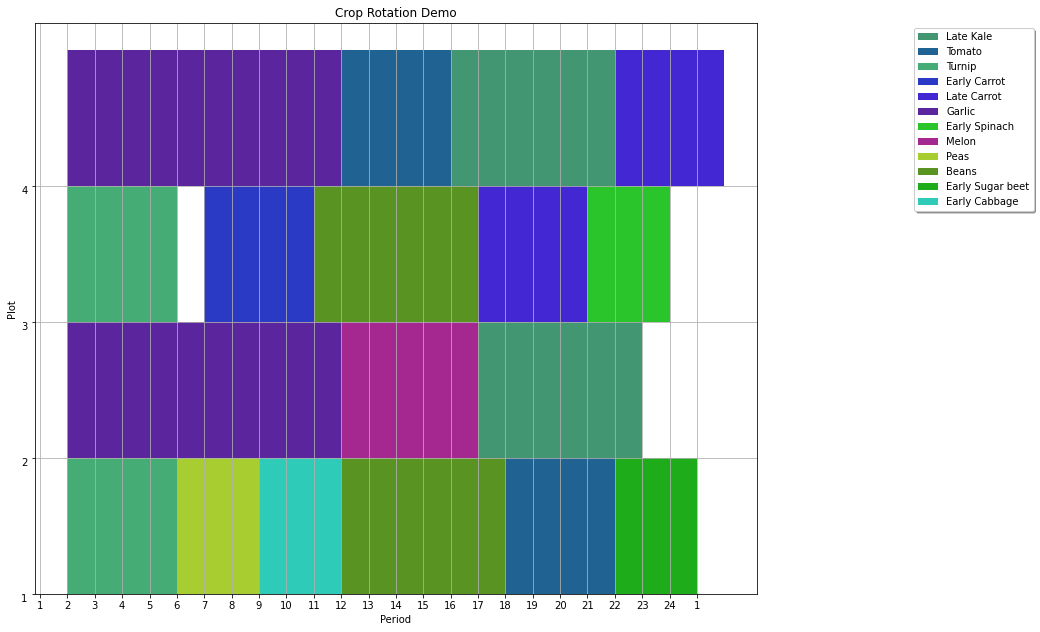

In [11]:
# Build a variable for each plot for each time and for each crop
x = [[[Binary('Crop{}Time{}Plot{}'.format(i, j, k))
                  for i in range(len(crops))]
                  for j in range(1, time_units + 1)] 
                  for k in range(len(plot_adjacency))]

# Initialize CQM
cqm = build_cqm()

# Instantiate the sampler
sampleset = solve(cqm)

# Parse solution
solution = parse_solution(sampleset)

# Print solution in a humam readable diagram
print_solution(solution)

In [13]:
solution

defaultdict(list,
            {(4, 16): ['Late Kale'],
             (2, 17): ['Late Kale'],
             (4, 12): ['Tomato'],
             (1, 18): ['Tomato'],
             (1, 2): ['Turnip'],
             (3, 2): ['Turnip'],
             (3, 7): ['Early Carrot'],
             (3, 17): ['Late Carrot'],
             (4, 22): ['Late Carrot'],
             (2, 2): ['Garlic'],
             (4, 2): ['Garlic'],
             (3, 21): ['Early Spinach'],
             (2, 12): ['Melon'],
             (1, 6): ['Peas'],
             (3, 11): ['Beans'],
             (1, 12): ['Beans'],
             (1, 22): ['Early Sugar beet'],
             (1, 9): ['Early Cabbage']})